In [1]:
import pandas as pd
import numpy as np
import cv2
import os

from joblib import Parallel, delayed

from matplotlib import pyplot as plt

from sklearn.mixture import GaussianMixture
import numpy as np

In [2]:
def data_benign(path, filenames):
    my_x = []
    my_y_np = np.array([])
    
    
    for filename in filenames:
        
        my_x.append(cv2.imread(os.path.join(path, filename), 0))
        my_y_np= np.append(my_y_np, np.array(0).astype(np.uint8))
        
    return np.array(my_x), my_y_np

In [3]:
def data_adversarial(path, filenames):
    my_x = []
    my_y_np = np.array([])
    
    
    for filename in filenames:
        
        my_x.append(cv2.imread(os.path.join(path, filename), 0))
        my_y_np= np.append(my_y_np, np.array(1).astype(np.uint8))
        
    return np.array(my_x), my_y_np

In [4]:
def data_test(path, filenames):
    my_x = []
    
    for filename in filenames:
        
        my_x.append(cv2.imread(os.path.join(path, filename), 0))
        
    return np.array(my_x)

# Read data

In [5]:
path_train_benign = os.path.join(os.getcwd(), "ch01-train")
filenames_train_benign = os.listdir(path_train_benign)

path_train_adversarial = os.path.join(os.getcwd(), "ch02-train")
filenames_train_adversarial = os.listdir(path_train_adversarial)

path_test = os.path.join(os.getcwd(), "ch02-test")
filenames_test = os.listdir(path_test)

In [6]:
X,y = data_benign(path_train_benign, filenames_train_benign)

In [7]:
X.shape

(60000, 28, 28)

In [8]:
X = X.reshape(60000,-1)
X.shape

(60000, 784)

In [9]:
X_adversarial, y_adversarial = data_adversarial(path_train_adversarial, filenames_train_adversarial)

In [10]:
X_adversarial = X_adversarial.reshape(60000,-1)
X_adversarial.shape

(60000, 784)

# Model benign data

In [11]:
def get_quality_of_model(gmm_model, X, criteria='bic'):
    if X.ndim ==1:
        X = X.reshape(-1,1)
        
    if criteria == 'bic':
        return gmm_model.bic(X)
    elif criteria == 'aic':
        return gmm_model.aic(X)
    else:
        print('nooo, select criteria plz !')

def parallel_get_best_gmm_for_data(X, max_number_of_components=10):
    ''' This function gives you the best gmm '''
    
    # create a model for each component from 1 to max_number_of_components
    gmm_comp_fit_func = lambda c : GaussianMixture(n_components=c, covariance_type='diag').fit(X)
    
    candidates = Parallel(n_jobs=10)(delayed(gmm_comp_fit_func)(components) 
                                         for components in range(1, max_number_of_components))
    
    # get the quality of all the models
    gmm_quality = [get_quality_of_model(mod, X, criteria='bic') for mod in candidates]
    
    # select the model with the best gmm_quality
    best_gmm_index = np.argmin(gmm_quality)
    
    print('Used components : ', best_gmm_index + 1)
    
    return candidates[best_gmm_index]

In [12]:
%%time
mega_gmm = parallel_get_best_gmm_for_data(X, max_number_of_components=10)

Used components :  9
Wall time: 3min 42s


# Get predictions of benign and (m)adversarial 

In [13]:
guts = mega_gmm.score_samples(X)
bads = mega_gmm.score_samples(X_adversarial)

# Investigating threshold

In [14]:
guts.mean(), bads.mean()

(-457.9932528078715, -154372769180.05084)

In [15]:
guts.std(), bads.std()

(1198.5852919404508, 85277479735.48149)

In [16]:
guts.min()

-142600.45958363757

In [17]:
np.quantile(guts, q=.000001)

-140313.37577727443

In [18]:
np.quantile(bads, q=.999999)

-256496479.23354307

''

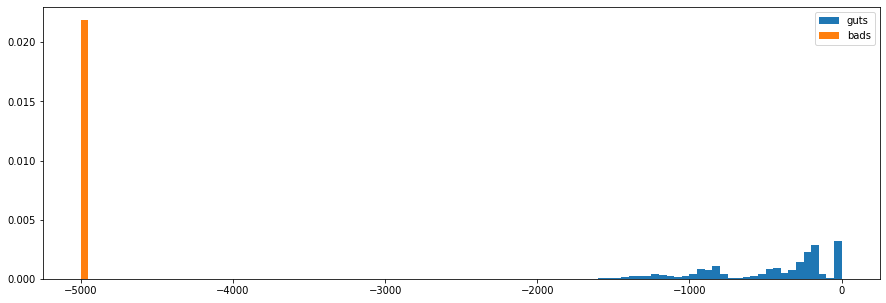

In [19]:
plt.figure(figsize=(15,5))
plt.hist(guts.clip(-5000, 0), bins=100, density=True, label='guts');
plt.hist(bads.clip(-5000, 0), bins=100, density=True, label='bads')
plt.legend();

# Classifier

In [20]:
def classifier(x):
    
    return int(mega_gmm.score_samples(x.reshape(1,-1)) < guts.min())

# Predict

In [21]:
X_test = data_test(path_test, filenames_test)

In [22]:
X_test = X_test.reshape(10000,-1)
X_test.shape

(10000, 784)

In [23]:
preds = []
for x in X_test:
    preds.append(classifier(x.reshape(1,-1)))

In [25]:
pd.Series(preds, index = filenames_test).to_csv("test_predictions_gmm.csv", header = None)

c:\users\m\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
